In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class TimeSeriesDataset(Dataset):
  def __init__(self, data, depth, step):
    super(TimeSeriesDataset, self).__init__()
    
    self.data = np.genfromtxt(data, delimiter="")
    self.x = []
    self.y = []

    for i in range(depth, len(self.data)-step+1):
      self.x.append(self.data[i-depth:i,:])
      self.y.append(self.data[i:i+step,-1])
    
    self.x = torch.tensor(np.array(self.x)).float().to(device)
    self.y = torch.tensor(np.array(self.y)).float().to(device)

    self.data_max = torch.tensor(self.data).float().max()
    self.data_min = torch.tensor(self.data).float().min()

    self.x = (self.x - self.data_min) / (self.data_max - self.data_min)
    self.y = (self.y - self.data_min) / (self.data_max - self.data_min)
  
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return len(self.x)

In [4]:
class CustomLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(CustomLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size

    gate_size = 4 * hidden_size

    self.w_ih = nn.Parameter(torch.Tensor(self.input_size, gate_size))
    self.w_hh = nn.Parameter(torch.Tensor(self.hidden_size, gate_size))
    
    self.b = nn.Parameter(torch.Tensor(gate_size))

    stdv = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-stdv, stdv)

  def forward(self, x):
    B, L = x.size(0), x.size(1)

    output = []

    ht = torch.zeros(B, self.hidden_size).to(device)
    ct = torch.zeros(B, self.hidden_size).to(device)

    for t in range(L):
      xt = x[:,t,:]
      gates = xt @ self.w_ih + ht @ self.w_hh + self.b

      it = torch.sigmoid(gates[:,:self.hidden_size])
      ft = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
      gt = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
      ot = torch.sigmoid(gates[:,3*self.hidden_size:])

      ct = ft * ct + it + gt
      ht = ot * torch.tanh(ct)

      output.append(ht.unsqueeze(1))

    output = torch.cat(output, dim=1)
    return output, (ht, ct)

In [5]:
class MultiStepPrediction(nn.Module):
  def __init__(self, input_size, hidden_size, step_size):
    super(MultiStepPrediction, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.step_size = step_size

    linear_size = self.step_size * self.hidden_size

    self.weight = nn.Parameter(torch.Tensor(linear_size, 1))
    self.bias = nn.Parameter(torch.Tensor(self.step_size))

    stdv = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-stdv, stdv)

    self.lstm = CustomLSTM(self.input_size+self.step_size-1, self.hidden_size)

  def forward(self, x):
    B, L, I = x.size()
    s = self.step_size
    
    xnew = x[:,:-(s-1),:]
    for i in range(1, s):
      xadd = x[:,i:(i+L-s+1),-1].unsqueeze(2)
      xnew = torch.cat([xnew, xadd], dim=2)

    label = []

    if s > 2:
      for i in range(1, s-1):
        label.append(x[:,-(s-i-1),-1].unsqueeze(1))
    
    for i in range(1, s):
      out, (ht, ct) = self.lstm(xnew)
      pred = ht @ self.weight[i*self.hidden_size:(i+1)*self.hidden_size,:] + self.bias[i]
      
      label.append(pred)

      ret = torch.cat(label[-(s-1):], dim=1)
      xnew = torch.cat([x[:,(L-s+i),:], ret], dim=1).unsqueeze(1)
    
    out, (ht, ct) = self.lstm(xnew)
    pred = ht @ self.weight[i*self.hidden_size:(i+1)*self.hidden_size,:] + self.bias[i]

    label.append(pred)

    ret = torch.cat(label[-s:], dim=1)
    return ret

In [6]:
train1 = TimeSeriesDataset("./train1.txt", depth=5, step=4)
DataLoader1 = DataLoader(train1, batch_size=32)

train2 = TimeSeriesDataset("./train2.txt", depth=5, step=4)
DataLoader2 = DataLoader(train2, batch_size=32)

test = TimeSeriesDataset("./test.txt", depth=5, step=4)

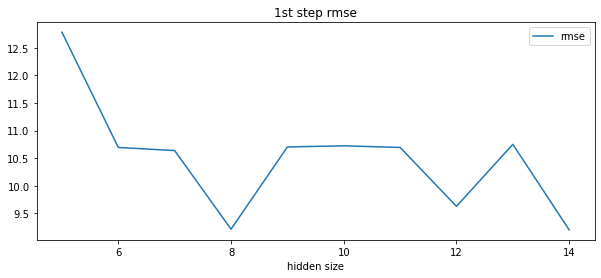

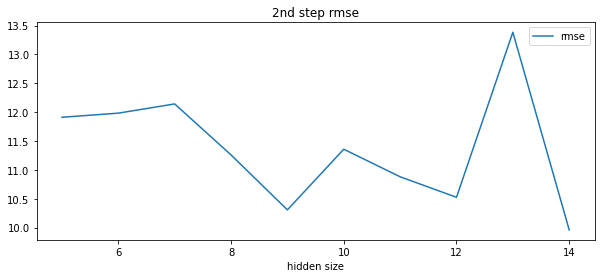

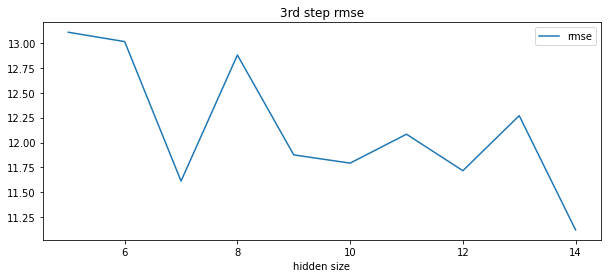

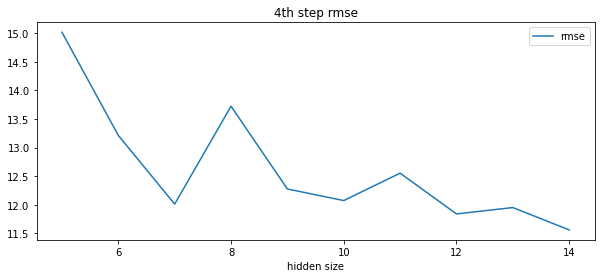

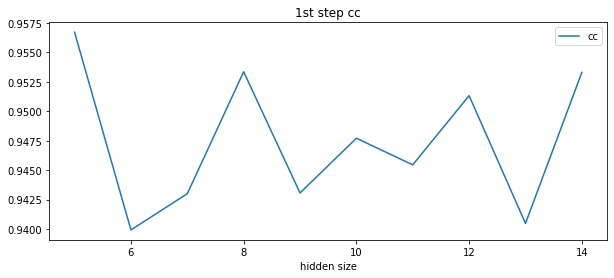

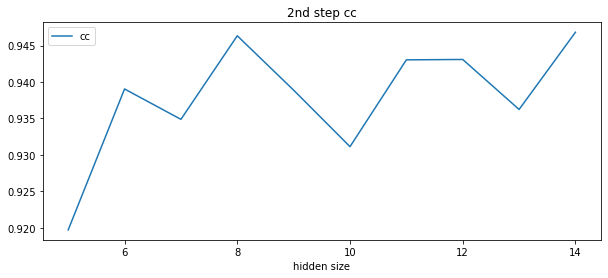

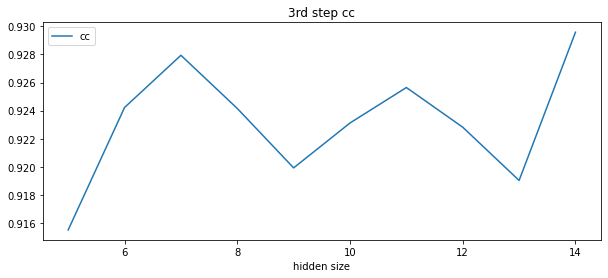

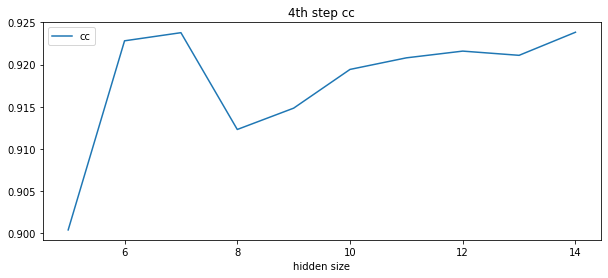

In [10]:
rmse1 = []
rmse2 = []
rmse3 = []
rmse4 = []

corrcoef1 = []
corrcoef2 = []
corrcoef3 = []
corrcoef4 = []

for hs in range(5, 15):
  model = MultiStepPrediction(input_size=9, hidden_size=hs, step_size=4).to(device)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(100):
    for i, data in enumerate(DataLoader1):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    for i, data in enumerate(DataLoader2):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
  
  label1 = []
  label2 = []
  label3 = []
  label4 = []

  output1 = []
  output2 = []
  output3 = []
  output4 = []

  for i in range(len(test)):
    x, y = test.__getitem__(i)
  
    x = x.unsqueeze(0)
    y = y * (test.data_max - test.data_min) + test.data_min
  
    label1.append(y[0].cpu().numpy())
    label2.append(y[1].cpu().numpy())
    label3.append(y[2].cpu().numpy())
    label4.append(y[3].cpu().numpy())
  
    output = model(x)
    output = output.squeeze(0)
    output = output * (test.data_max - test.data_min) + test.data_min

    output1.append(output[0].detach().cpu().numpy())
    output2.append(output[1].detach().cpu().numpy())
    output3.append(output[2].detach().cpu().numpy())
    output4.append(output[3].detach().cpu().numpy())

  label1 = np.array(label1)
  output1 = np.array(output1)

  corrcoef1.append(np.corrcoef(label1, output1)[0][1])
  rmse1.append(np.sqrt(sum((label1 - output1)**2)))

  label2 = np.array(label2)
  output2 = np.array(output2)

  corrcoef2.append(np.corrcoef(label2, output2)[0][1])
  rmse2.append(np.sqrt(sum((label2 - output2)**2)))

  label3 = np.array(label3)
  output3 = np.array(output3)

  corrcoef3.append(np.corrcoef(label3, output3)[0][1])
  rmse3.append(np.sqrt(sum((label3 - output3)**2)))

  label4 = np.array(label4)
  output4 = np.array(output4)

  corrcoef4.append(np.corrcoef(label4, output4)[0][1])
  rmse4.append(np.sqrt(sum((label4 - output4)**2)))

fig = plt.figure(figsize=(10, 4))
plt.title("1st step rmse")
plt.plot(range(5, 15), rmse1, label="rmse")
plt.xlabel("hidden size")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("2nd step rmse")
plt.plot(range(5, 15), rmse2, label="rmse")
plt.xlabel("hidden size")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("3rd step rmse")
plt.plot(range(5, 15), rmse3, label="rmse")
plt.xlabel("hidden size")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("4th step rmse")
plt.plot(range(5, 15), rmse4, label="rmse")
plt.xlabel("hidden size")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("1st step cc")
plt.plot(range(5, 15), corrcoef1, label="cc")
plt.xlabel("hidden size")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("2nd step cc")
plt.plot(range(5, 15), corrcoef2, label="cc")
plt.xlabel("hidden size")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("3rd step cc")
plt.plot(range(5, 15), corrcoef3, label="cc")
plt.xlabel("hidden size")
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("4th step cc")
plt.plot(range(5, 15), corrcoef4, label="cc")
plt.xlabel("hidden size")
plt.legend()
plt.show()

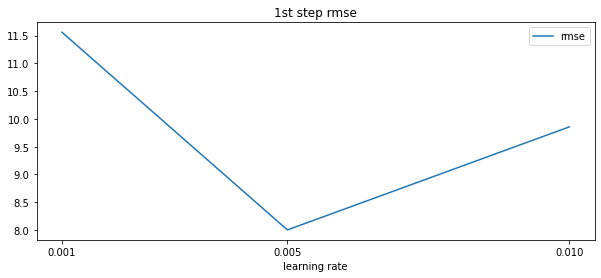

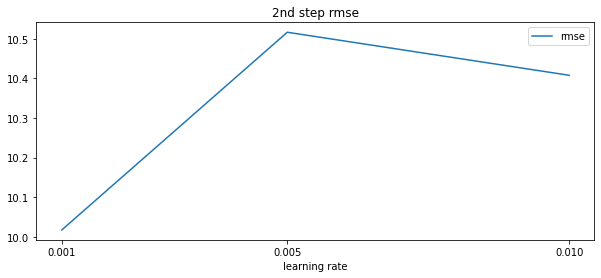

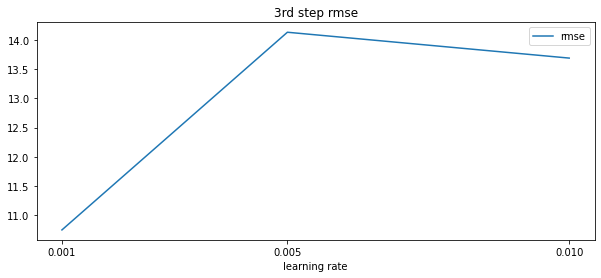

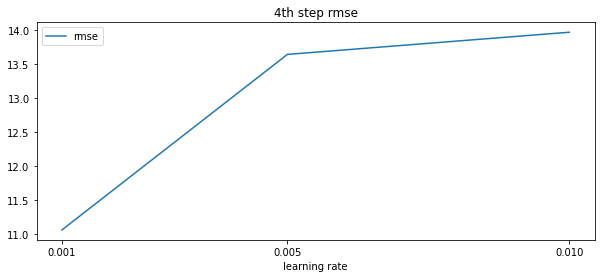

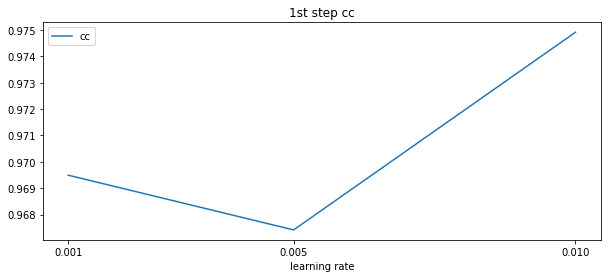

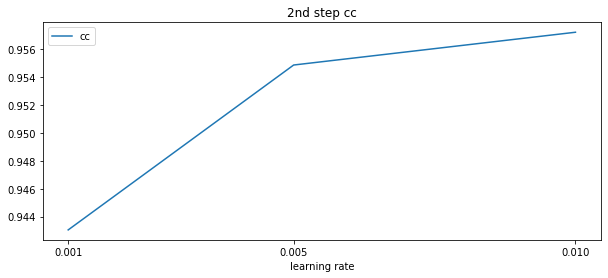

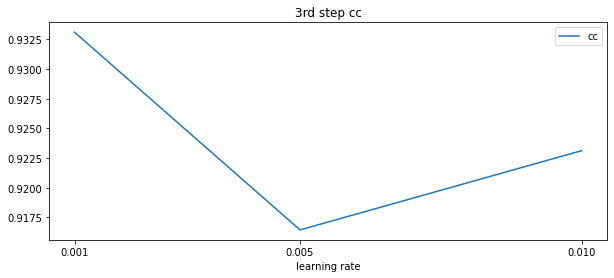

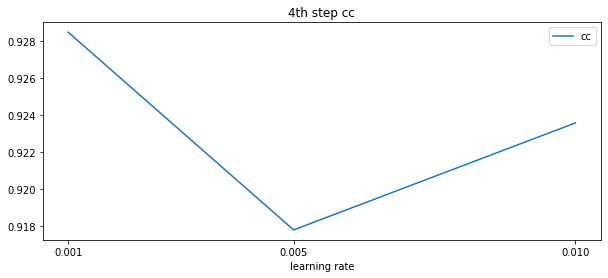

In [15]:
rmse1 = []
rmse2 = []
rmse3 = []
rmse4 = []

corrcoef1 = []
corrcoef2 = []
corrcoef3 = []
corrcoef4 = []

lr_list = [1e-2, 0.005, 1e-3]

for lr in lr_list:
  model = MultiStepPrediction(input_size=9, hidden_size=14, step_size=4).to(device)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(100):
    for i, data in enumerate(DataLoader1):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    for i, data in enumerate(DataLoader2):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
  
  label1 = []
  label2 = []
  label3 = []
  label4 = []

  output1 = []
  output2 = []
  output3 = []
  output4 = []

  for i in range(len(test)):
    x, y = test.__getitem__(i)
  
    x = x.unsqueeze(0)
    y = y * (test.data_max - test.data_min) + test.data_min
  
    label1.append(y[0].cpu().numpy())
    label2.append(y[1].cpu().numpy())
    label3.append(y[2].cpu().numpy())
    label4.append(y[3].cpu().numpy())
  
    output = model(x)
    output = output.squeeze(0)
    output = output * (test.data_max - test.data_min) + test.data_min

    output1.append(output[0].detach().cpu().numpy())
    output2.append(output[1].detach().cpu().numpy())
    output3.append(output[2].detach().cpu().numpy())
    output4.append(output[3].detach().cpu().numpy())

  label1 = np.array(label1)
  output1 = np.array(output1)

  corrcoef1.append(np.corrcoef(label1, output1)[0][1])
  rmse1.append(np.sqrt(sum((label1 - output1)**2)))

  label2 = np.array(label2)
  output2 = np.array(output2)

  corrcoef2.append(np.corrcoef(label2, output2)[0][1])
  rmse2.append(np.sqrt(sum((label2 - output2)**2)))

  label3 = np.array(label3)
  output3 = np.array(output3)

  corrcoef3.append(np.corrcoef(label3, output3)[0][1])
  rmse3.append(np.sqrt(sum((label3 - output3)**2)))

  label4 = np.array(label4)
  output4 = np.array(output4)

  corrcoef4.append(np.corrcoef(label4, output4)[0][1])
  rmse4.append(np.sqrt(sum((label4 - output4)**2)))

fig = plt.figure(figsize=(10, 4))
plt.title("1st step rmse")
plt.plot(lr_list, rmse1, label="rmse")
plt.xlabel("learning rate")
plt.xticks(lr_list)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("2nd step rmse")
plt.plot(lr_list, rmse2, label="rmse")
plt.xlabel("learning rate")
plt.xticks(lr_list)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("3rd step rmse")
plt.plot(lr_list, rmse3, label="rmse")
plt.xlabel("learning rate")
plt.xticks(lr_list)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("4th step rmse")
plt.plot(lr_list, rmse4, label="rmse")
plt.xlabel("learning rate")
plt.xticks(lr_list)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("1st step cc")
plt.plot(lr_list, corrcoef1, label="cc")
plt.xlabel("learning rate")
plt.xticks(lr_list)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("2nd step cc")
plt.plot(lr_list, corrcoef2, label="cc")
plt.xlabel("learning rate")
plt.xticks(lr_list)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("3rd step cc")
plt.plot(lr_list, corrcoef3, label="cc")
plt.xlabel("learning rate")
plt.xticks(lr_list)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("4th step cc")
plt.plot(lr_list, corrcoef4, label="cc")
plt.xlabel("learning rate")
plt.xticks(lr_list)
plt.legend()
plt.show()

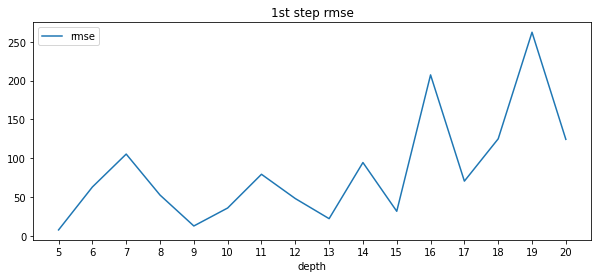

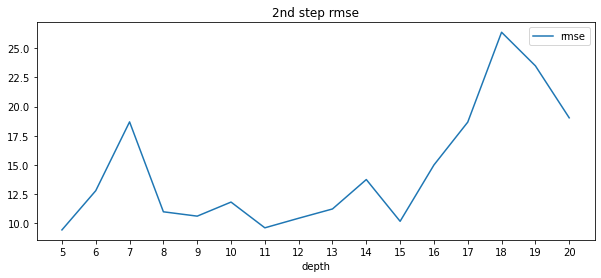

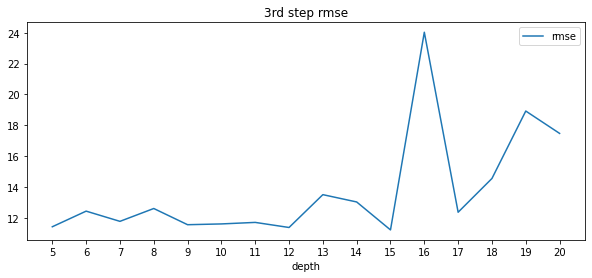

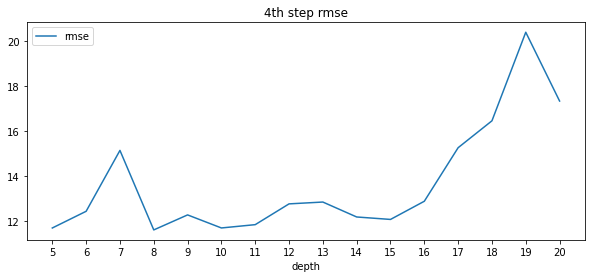

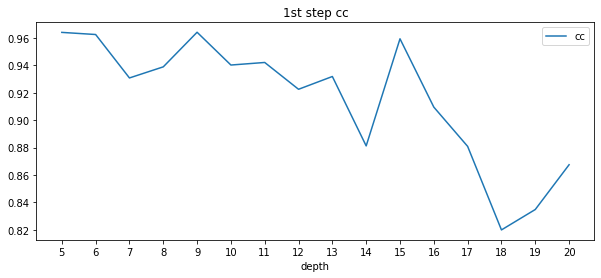

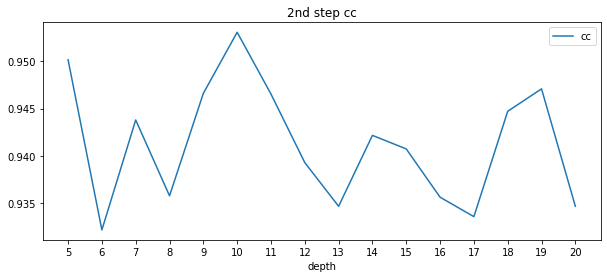

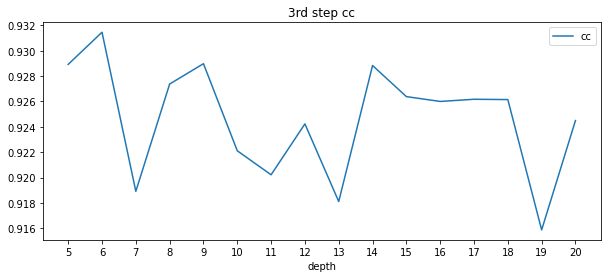

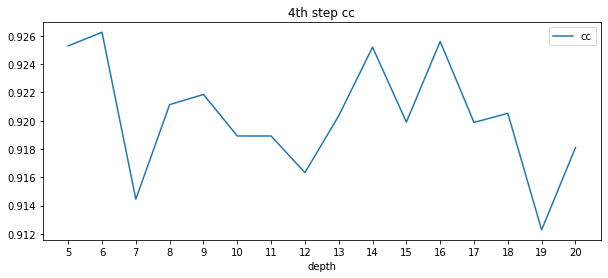

In [16]:
rmse1 = []
rmse2 = []
rmse3 = []
rmse4 = []

corrcoef1 = []
corrcoef2 = []
corrcoef3 = []
corrcoef4 = []

for d in range(5, 21):
  train1 = TimeSeriesDataset("./train1.txt", depth=d, step=4)
  DataLoader1 = DataLoader(train1, batch_size=32)

  train2 = TimeSeriesDataset("./train2.txt", depth=d, step=4)
  DataLoader2 = DataLoader(train2, batch_size=32)

  model = MultiStepPrediction(input_size=9, hidden_size=14, step_size=4).to(device)
  criterion = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  for epoch in range(100):
    for i, data in enumerate(DataLoader1):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    for i, data in enumerate(DataLoader2):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
  
  label1 = []
  label2 = []
  label3 = []
  label4 = []

  output1 = []
  output2 = []
  output3 = []
  output4 = []

  for i in range(len(test)):
    x, y = test.__getitem__(i)
  
    x = x.unsqueeze(0)
    y = y * (test.data_max - test.data_min) + test.data_min
  
    label1.append(y[0].cpu().numpy())
    label2.append(y[1].cpu().numpy())
    label3.append(y[2].cpu().numpy())
    label4.append(y[3].cpu().numpy())
  
    output = model(x)
    output = output.squeeze(0)
    output = output * (test.data_max - test.data_min) + test.data_min

    output1.append(output[0].detach().cpu().numpy())
    output2.append(output[1].detach().cpu().numpy())
    output3.append(output[2].detach().cpu().numpy())
    output4.append(output[3].detach().cpu().numpy())

  label1 = np.array(label1)
  output1 = np.array(output1)

  corrcoef1.append(np.corrcoef(label1, output1)[0][1])
  rmse1.append(np.sqrt(sum((label1 - output1)**2)))

  label2 = np.array(label2)
  output2 = np.array(output2)

  corrcoef2.append(np.corrcoef(label2, output2)[0][1])
  rmse2.append(np.sqrt(sum((label2 - output2)**2)))

  label3 = np.array(label3)
  output3 = np.array(output3)

  corrcoef3.append(np.corrcoef(label3, output3)[0][1])
  rmse3.append(np.sqrt(sum((label3 - output3)**2)))

  label4 = np.array(label4)
  output4 = np.array(output4)

  corrcoef4.append(np.corrcoef(label4, output4)[0][1])
  rmse4.append(np.sqrt(sum((label4 - output4)**2)))

fig = plt.figure(figsize=(10, 4))
plt.title("1st step rmse")
plt.plot(range(5, 21), rmse1, label="rmse")
plt.xlabel("depth")
plt.xticks(range(5, 21))
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("2nd step rmse")
plt.plot(range(5, 21), rmse2, label="rmse")
plt.xlabel("depth")
plt.xticks(range(5, 21))
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("3rd step rmse")
plt.plot(range(5, 21), rmse3, label="rmse")
plt.xlabel("depth")
plt.xticks(range(5, 21))
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("4th step rmse")
plt.plot(range(5, 21), rmse4, label="rmse")
plt.xlabel("depth")
plt.xticks(range(5, 21))
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("1st step cc")
plt.plot(range(5, 21), corrcoef1, label="cc")
plt.xlabel("depth")
plt.xticks(range(5, 21))
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("2nd step cc")
plt.plot(range(5, 21), corrcoef2, label="cc")
plt.xlabel("depth")
plt.xticks(range(5, 21))
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("3rd step cc")
plt.plot(range(5, 21), corrcoef3, label="cc")
plt.xlabel("depth")
plt.xticks(range(5, 21))
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 4))
plt.title("4th step cc")
plt.plot(range(5, 21), corrcoef4, label="cc")
plt.xlabel("depth")
plt.xticks(range(5, 21))
plt.legend()
plt.show()